In [1]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-beta1

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.2.0-rc3


In [0]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

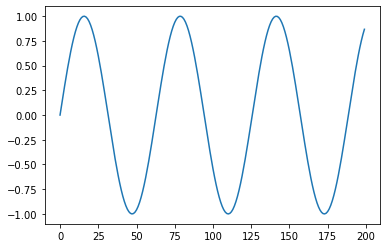

In [3]:
# make the original data
series = np.sin(0.1*np.arange(200)) #+ np.random.randn(200)*0.1

# plot it
plt.plot(series)
plt.show()

In [15]:
print(series)

[ 0.          0.09983342  0.19866933  0.29552021  0.38941834  0.47942554
  0.56464247  0.64421769  0.71735609  0.78332691  0.84147098  0.89120736
  0.93203909  0.96355819  0.98544973  0.99749499  0.9995736   0.99166481
  0.97384763  0.94630009  0.90929743  0.86320937  0.8084964   0.74570521
  0.67546318  0.59847214  0.51550137  0.42737988  0.33498815  0.23924933
  0.14112001  0.04158066 -0.05837414 -0.15774569 -0.2555411  -0.35078323
 -0.44252044 -0.52983614 -0.61185789 -0.68776616 -0.7568025  -0.81827711
 -0.87157577 -0.91616594 -0.95160207 -0.97753012 -0.993691   -0.99992326
 -0.99616461 -0.98245261 -0.95892427 -0.92581468 -0.88345466 -0.83226744
 -0.77276449 -0.70554033 -0.63126664 -0.55068554 -0.46460218 -0.37387666
 -0.2794155  -0.1821625  -0.0830894   0.0168139   0.1165492   0.21511999
  0.31154136  0.40484992  0.49411335  0.57843976  0.6569866   0.72896904
  0.79366786  0.85043662  0.8987081   0.93799998  0.96791967  0.98816823
  0.99854335  0.99894134  0.98935825  0.96988981  0

In [4]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (190, 10) Y.shape (190,)


In [5]:
### try autoregressive linear model
i = Input(shape=(T,))
x = Dense(1)(i)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.1),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
3/3 [==============================] - 0s 81ms/step - loss: 0.3195 - val_loss: 0.3083
Epoch 2/80
3/3 [==============================] - 0s 14ms/step - loss: 0.2597 - val_loss: 0.0073
Epoch 3/80
3/3 [==============================] - 0s 14ms/step - loss: 0.0673 - val_loss: 0.1164
Epoch 4/80
3/3 [==============================] - 0s 13ms/step - loss: 0.1122 - val_loss: 0.0050
Epoch 5/80
3/3 [==============================] - 0s 13ms/step - loss: 0.0308 - val_loss: 0.0664
Epoch 6/80
3/3 [==============================] - 0s 13ms/step - loss: 0.0512 - val_loss: 0.0022
Epoch 7/80
3/3 [==============================] - 0s 12ms/step - loss: 0.0121 - val_loss: 0.0467
Epoch 8/80
3/3 [==============================] - 0s 12ms/step - loss: 0.0311 - val_loss: 0.0086
Epoch 9/80
3/3 [==============================] - 0s 11ms/step - loss: 0.0057 - val_loss: 0.0153
Epoch 10/80
3/3 [==============================] - 0s 13ms/step - loss: 0.0175 - val_loss: 0.0042
Epoch 11/80
3/3 [============

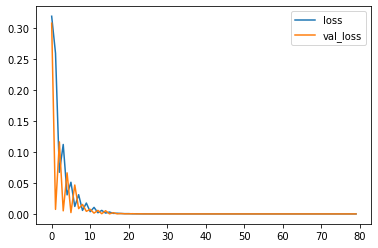

In [6]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

In [0]:
# "Wrong" forecast using true targets

validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = -N//2

while len(validation_predictions) < len(validation_target):
  p = model.predict(X[i].reshape(1, -1))[0,0] # 1x1 array -> scalar
  i += 1
  
  # update the predictions list
  validation_predictions.append(p)

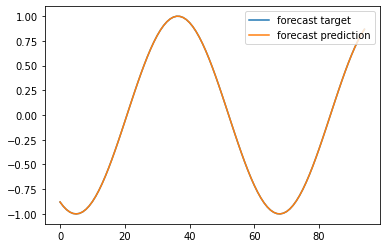

In [8]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [0]:
# Forecast future values (use only self-predictions for making future predictions)

validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, -1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

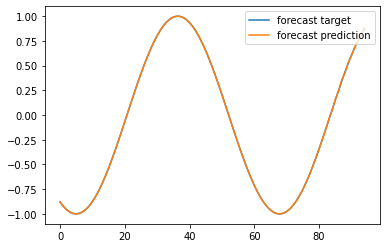

In [10]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [0]:
model.save('TF2.0_AUTOREGRESSIVE_MODEL.h5')